## 1. Setup and Import libraries

In [1]:
# django path
mysite_path = "C:\\Data\\UCL\\@MSc Project\\DB\\mysite\\"

In [2]:
# standard packages
import os
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import django
from set_django_db import set_django_db
from asgiref.sync import sync_to_async

from IPython.core.display import HTML

%matplotlib inline

In [3]:
# set django models
set_django_db(mysite_path)
from tables_daniel.models import Company, Review

# specifically for Jupyter notebooks
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [4]:
# center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical_align: middle;
}
</style>
""")

## 2. Load, merge and filter the datasets

<hr>

**Content**

    2.1 Load companies
    2.2 Load reviews
    2.3 Some useful merges/adds
    2.4 Filter the data from the monitored period between 2018-07-01 and 2020-06-30
    2.5 Filter only the reviews for the companies with at least 10 reviews
    2.6 Add a column concatenating pros & cons
    2.7 Update employee relatioship

### 2.1 Companies

In [5]:
companies = pd.DataFrame(
    list(
        Company
        .objects
        .values('id', 'Company', 'Sector', 'ListedOn')
        .all()
    )
)

companies_id = list(companies.id)

### 2.2 Reviews

In [6]:
reviews = list(
    Review
    .objects
    .values(
        'id', 'Company_id', 'ReviewTitle', 'Rating',
        'JobTitle', 'EmployeeRelationship',
        'Contract', 'Pros', 'Cons',
        'Year', 'Month', 'Day'
    )
    .all()
    .filter(Company_id = company_id) for company_id in companies_id
)

reviews_df = pd.DataFrame(
    sum([list(reviews_i) for reviews_i in reviews],[])
).drop_duplicates()

In [7]:
"""
for i in range(reviews_df.shape[0]):
    row = dict(reviews_df.iloc[i,:])
    
    review = (
        Review
        .objects
        .values('id', 'JobTitle' ,'EmployeeRelationship')
        .get(id=row['id'])
    )
    
    if review['JobTitle'] in ['Former Employee', 'Current Employee']:
        new_jobTitle = review['EmployeeRelationship']
        new_relationship = review['JobTitle']
        
        (Review
         .objects
         .filter(id=row['id'])
         .update(
             JobTitle = new_jobTitle,
             EmployeeRelationship = new_relationship
         )
        )
    else:
        pass
    
    if (i+1)%100==0:
        print(i+1)
"""

"\nfor i in range(reviews_df.shape[0]):\n    row = dict(reviews_df.iloc[i,:])\n    \n    review = (\n        Review\n        .objects\n        .values('id', 'JobTitle' ,'EmployeeRelationship')\n        .get(id=row['id'])\n    )\n    \n    if review['JobTitle'] in ['Former Employee', 'Current Employee']:\n        new_jobTitle = review['EmployeeRelationship']\n        new_relationship = review['JobTitle']\n        \n        (Review\n         .objects\n         .filter(id=row['id'])\n         .update(\n             JobTitle = new_jobTitle,\n             EmployeeRelationship = new_relationship\n         )\n        )\n    else:\n        pass\n    \n    if (i+1)%100==0:\n        print(i+1)\n"

### 2.3 Some useful merges/adds

In [8]:
# add sector and company name
reviews_df = reviews_df.merge(
    companies[['id', 'Company', 'Sector', 'ListedOn']].rename(columns={'id': 'Company_id'}),
    on='Company_id'
)

# add date column used for filtering
reviews_df['Date'] = reviews_df.apply(lambda x: '-'.join(
    [str(x['Year']), str(x['Month']), str(x['Day'])]
    ), axis=1
)

reviews_df

id  Company_id                                       ReviewTitle  \
0       24966           1                                         Part Time   
1       24967           1                               Terrible experience   
2       24968           1                                               Top   
3       24969           1                                   Sales Assistant   
4       24970           1  My experience is too maintain the task and group   
...       ...         ...                                               ...   
403060  81560         649                                            Review   
403061  81561         649                                 Engaging Projects   
403062  81562         649                    Healthcare and 401k are a joke   
403063  81563         649                            Where hacks go to die.   
403064  81564         649                No one here gets out alive. Avoid.   

        Rating                JobTitle EmployeeRelationship   Contract  \
0          4.0      Anonymous Employee      Former Employee  part-time   
1          1.0       Software Engineer      Former Employee  full-time   
2          5.0              Manager/In     Current Employee  full-time   
3          4.0         Sales Assistant      Former Employee  part-time   
4          2.0       Questions Solving      Former Employee  part-time   
...        ...                     ...                  ...        ...   
403060     4.0      Anonymous Employee      Former Employee  full-time   
403061     4.0  Senior Project Manager      Former Employee  full-time   
403062     1.0      Anonymous Employee     Current Employee  full-time   
403063     1.0      Anonymous Employee      Former Employee  full-time   
403064     1.0      Anonymous Employee      Former Employee  full-time   

                                                     Pros  \
0       Friendly colleagues, willing to give you disco...   
1       Some nice welcoming colleagues and benefits (M...   
2              Work-Life Balance, nice offices, top sport   
3         Staff helpfulPay was goof Staff are respectuful   
4          My biggest dream is to work with Adidas family   
...                                                   ...   
403060  Work-life balance, great if you have a young f...   
403061  Flexibility, Responsibility, Authority to get ...   
403062                none  - 401k match is extremely low   
403063               Lack of talent is considered a plus.   
403064                   Ok salary. Work/life balance ok.   

                                                     Cons  Year  Month  Day  \
0       There are some politics going on (like any oth...  2020      7    1   
1       Really poor culture and collaboration spirit, ...  2020      7    1   
2                    Global company, long decision making  2020      6   30   
3                               Might get a little hectic  2020      6   29   
4       Difficult to maintain but once know easy to ha...  2020      6   28   
...                                                   ...   ...    ...  ...   
403060              Lack of structured career progression  2018      8   27   
403061  Working across agencies is fun but rarely stru...  2018      8   18   
403062  401k has a tiny match, why bother?Healthcare i...  2018      8   16   
403063  Impersonal, low paying, account folk rule the ...  2018      7   17   
403064  Difficult to know where to begin. Basically, d...  2018      6   26   

        Company                  Sector       ListedOn       Date  
0        Adidas       Consumer Cyclical  EURO STOXX 50   2020-7-1  
1        Adidas       Consumer Cyclical  EURO STOXX 50   2020-7-1  
2        Adidas       Consumer Cyclical  EURO STOXX 50  2020-6-30  
3        Adidas       Consumer Cyclical  EURO STOXX 50  2020-6-29  
4        Adidas       Consumer Cyclical  EURO STOXX 50  2020-6-28  
...         ...                     ...            ...        ...  
403060  WPP plc

In [9]:
def string_to_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')
    
def string_to_YM(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m')
    except:
        return datetime.strptime('1800-1-1', '%Y-%m-%d')

reviews_df['Date'] = reviews_df['Date'].apply(lambda x: string_to_date(x))

reviews_df['Year-Month'] = reviews_df.apply(lambda x: string_to_YM('-'.join([str(x['Year']), str(x['Month'])])), axis=1)

### 2.4 Filter the data from the monitored period between 

In [10]:
# further analysis focusing only on the companies with at least 10 reviews in the monitored period
min_date = datetime.strptime('2018-7-1', '%Y-%m-%d')
max_date = datetime.strptime('2020-6-30', '%Y-%m-%d')

reviews_df = pd.DataFrame(
    reviews_df[(reviews_df.Date >= min_date) & (reviews_df.Date <= max_date)]
)

reviews_df

id  Company_id                                       ReviewTitle  \
2       24968           1                                               Top   
3       24969           1                                   Sales Assistant   
4       24970           1  My experience is too maintain the task and group   
5       24971           1                                         great job   
6       24972           1                             Sales Floor Team lead   
...       ...         ...                                               ...   
403059  81559         649                   Don't even consider going there   
403060  81560         649                                            Review   
403061  81561         649                                 Engaging Projects   
403062  81562         649                    Healthcare and 401k are a joke   
403063  81563         649                            Where hacks go to die.   

        Rating                JobTitle EmployeeRelationship   Contract  \
2          5.0              Manager/In     Current Employee  full-time   
3          4.0         Sales Assistant      Former Employee  part-time   
4          2.0       Questions Solving      Former Employee  part-time   
5          4.0  Retail Sales Associate      Former Employee  part-time   
6          3.0               Team Lead      Former Employee  full-time   
...        ...                     ...                  ...        ...   
403059     1.0        Account Director      Former Employee  full-time   
403060     4.0      Anonymous Employee      Former Employee  full-time   
403061     4.0  Senior Project Manager      Former Employee  full-time   
403062     1.0      Anonymous Employee     Current Employee  full-time   
403063     1.0      Anonymous Employee      Former Employee  full-time   

                                                     Pros  \
2              Work-Life Balance, nice offices, top sport   
3         Staff helpfulPay was goof Staff are respectuful   
4          My biggest dream is to work with Adidas family   
5            cool team fun work environment great company   
6       employee discount 40-60% most items excluding ...   
...                                                   ...   
403059          - There are some talented and nice people   
403060  Work-life balance, great if you have a young f...   
403061  Flexibility, Responsibility, Authority to get ...   
403062                none  - 401k match is extremely low   
403063               Lack of talent is considered a plus.   

                                                     Cons  Year  Month  Day  \
2                    Global company, long decision making  2020      6   30   
3                               Might get a little hectic  2020      6   29   
4       Difficult to maintain but once know easy to ha...  2020      6   28   
5                   dealing with some difficult customers  2020      6   28   
6       low paid job, almost much minimum wage to star...  2020      6   27   
...                                                   ...   ...    ...  ...   
403059  - Lives up to all the bad stereotypes of agenc...  2018      8   28   
403060              Lack of structured career progression  2018      8   27   
403061  Working across agencies is fun but rarely stru...  2018      8   18   
403062  401k has a tiny match, why bother?Healthcare i...  2018      8   16   
403063  Impersonal, low paying, account folk rule the ...  2018      7   17   

        Company                  Sector       ListedOn       Date Year-Month  
2        Adidas       Consumer Cyclical  EURO STOXX 50 2020-06-30 2020-06-01  
3        Adidas       Consumer Cyclical  EURO STOXX 50 2020-06-29 2020-06-01  
4        Adidas       Consumer Cyclical  EURO STOXX 50 2020-06-28 2020-06-01  
5        Adidas       Consumer Cyclical  EURO STOXX 50 2020-06-28 2020-06-01  
6        Adidas       Consumer Cyclical  EURO STOXX 50 2020-06-27 2020-06-01  
...         ...  

### 2.5 Filter only the reviews for companies with at least 10 reviews

In [11]:
# count reviews
reviews_count = (
    reviews_df
    .groupby('Company')
    .Rating
    .count()
)

# filter companies
companies_filtered = list(reviews_count[reviews_count>10].index)

In [12]:
reviews_df = reviews_df[reviews_df.Company.isin(companies_filtered)]

print(
    f"There are {reviews_df.shape[0]:.0f} reviews in total."
)

There are 392408 reviews in total.


### 2.6 Add a column of concatenated pros & cons + their length

In [13]:
reviews_df['Review'] = reviews_df['Pros'] + ' ' + reviews_df['Cons']

reviews_df['ReviewLength'] = reviews_df['Review'].apply(lambda x: len(x))

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
reviews_df.head()

id  Company_id                                       ReviewTitle  \
2  24968           1                                               Top   
3  24969           1                                   Sales Assistant   
4  24970           1  My experience is too maintain the task and group   
5  24971           1                                         great job   
6  24972           1                             Sales Floor Team lead   

   Rating                JobTitle EmployeeRelationship   Contract  \
2     5.0              Manager/In     Current Employee  full-time   
3     4.0         Sales Assistant      Former Employee  part-time   
4     2.0       Questions Solving      Former Employee  part-time   
5     4.0  Retail Sales Associate      Former Employee  part-time   
6     3.0               Team Lead      Former Employee  full-time   

                                                Pros  \
2         Work-Life Balance, nice offices, top sport   
3    Staff helpfulPay was goof Staff are respectuful   
4     My biggest dream is to work with Adidas family   
5       cool team fun work environment great company   
6  employee discount 40-60% most items excluding ...   

                                                Cons  Year  Month  Day  \
2               Global company, long decision making  2020      6   30   
3                          Might get a little hectic  2020      6   29   
4  Difficult to maintain but once know easy to ha...  2020      6   28   
5              dealing with some difficult customers  2020      6   28   
6  low paid job, almost much minimum wage to star...  2020      6   27   

  Company             Sector       ListedOn       Date Year-Month  \
2  Adidas  Consumer Cyclical  EURO STOXX 50 2020-06-30 2020-06-01   
3  Adidas  Consumer Cyclical  EURO STOXX 50 2020-06-29 2020-06-01   
4  Adidas  Consumer Cyclical  EURO STOXX 50 2020-06-28 2020-06-01   
5  Adidas  Consumer Cyclical  EURO STOXX 50 2020-06-28 2020-06-01   
6  Adidas  Consumer Cyclical  EURO STOXX 50 2020-06-27 2020-06-01   

                                              Review  ReviewLength  
2  Work-Life Balance, nice offices, top sport Glo...            79  
3  Staff helpfulPay was goof Staff are respectufu...            73  
4  My biggest dream is to work with Adidas family...            97  
5  cool team fun work environment great company d...            82  
6  employee discount 40-60% most items excluding ...           396

### 2.7 Update employee relationship

In [15]:
def update_EmployeeRelationship(x):
    if x not in ['Current Employee', 'Former Employee']:
        return 'Not specified'
    else:
        return x
    
reviews_df['EmployeeRelationship'] = [update_EmployeeRelationship(reviews_df.loc[row, 'EmployeeRelationship']) for row in reviews_df.index]

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### 2.8 Add columns with total reviews to companies_df

In [16]:
# 1. get number of reviews per company
reviewsPerCompany = (
    reviews_df
    .groupby('Company')
    .Rating
    .count()
)

In [17]:
# 1. get number of reviews per company
reviewsPerCompany = (
    reviews_df
    .groupby('Company')
    .Rating
    .count()
)

# 2. assign these values to company_df
companies_filtered_df = companies[companies.Company.isin(companies_filtered)]
companies_filtered_df['TotalReviews'] = 0
companies_filtered_df['TotalReviews'] = [reviewsPerCompany.loc[company] for company in companies_filtered_df.Company]

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## 3. Summary statistics

<hr>

**Content**
    
    3.1 Distribution of ratings/reviews over former/current and part/full-time employees
    3.2 Mean, median, standard deviation and quantiles of total reviews per company
    3.3 Mean, meadin, std and quantiles per sectors

In [18]:
# helper quantile/quartile functions

def q1(x):
    return x.quantile(.25)

def q3(x):
    return x.quantile(.75)

def q10(x):
    return x.quantile(.1)

def q90(x):
    return x.quantile(.9)

In [19]:
# Overall rating stats

print(
    reviews_df
    .Rating
    .agg(['mean', 'std', q1, 'median', q3])
)

mean      3.610497
std       1.228502
q1        3.000000
median    4.000000
q3        5.000000
Name: Rating, dtype: float64


In [20]:
# Overall reviews stats

print(
    reviews_df
    .ReviewLength
    .agg(['mean', 'std', q1, 'median', q3])
)

mean      198.459048
std       290.027821
q1         81.000000
median    112.000000
q3        197.000000
Name: ReviewLength, dtype: float64


### 3.1 Distribution of ratings/reviews over former/current and part/full-time employees

In [21]:
print(
    reviews_df
    .groupby('Contract')
    .Rating
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

            count      mean       std   q1  median   q3
Contract                                               
            18043  3.504683  1.293533  3.0     4.0  5.0
full-time  316117  3.626034  1.234190  3.0     4.0  5.0
part-time   58240  3.558946  1.172597  3.0     4.0  4.0


In [22]:
print(
    reviews_df
    .groupby('EmployeeRelationship')
    .Rating
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

                       count      mean       std   q1  median   q3
EmployeeRelationship                                              
Current Employee      220135  3.800568  1.155948  3.0     4.0  5.0
Former Employee       154224  3.351580  1.271634  3.0     4.0  4.0
Not specified          18041  3.504628  1.293594  3.0     4.0  5.0


In [23]:
print(
    reviews_df
    .groupby('Contract')
    .ReviewLength
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

            count        mean         std  q1  median   q3
Contract                                                  
            18051  176.439699  263.855592  76     104  169
full-time  316117  205.192846  300.320423  82     115  204
part-time   58240  168.733826  233.132379  76     103  167


In [24]:
print(
    reviews_df
    .groupby('EmployeeRelationship')
    .ReviewLength
    .agg(['count', 'mean', 'std', q1, 'median', q3])
)

                       count        mean         std  q1  median   q3
EmployeeRelationship                                                 
Current Employee      220135  193.473196  268.526755  81     112  195
Former Employee       154224  208.151915  320.575667  82     114  202
Not specified          18049  176.446063  263.869329  76     104  169


### 3.2 Mean, median, standard deviation and quantiles of total reviews per company

In [25]:
print(
    reviews_df
    .groupby('Company')
    .Rating
    .count()
    .agg(['mean', 'std', q10, q1, 'median', q3, q90, 'max'])
)   

mean        648.595041
std        1680.993707
q10          39.400000
q1           83.000000
median      214.000000
q3          559.000000
q90        1361.200000
max       27455.000000
Name: Rating, dtype: float64


**Global**

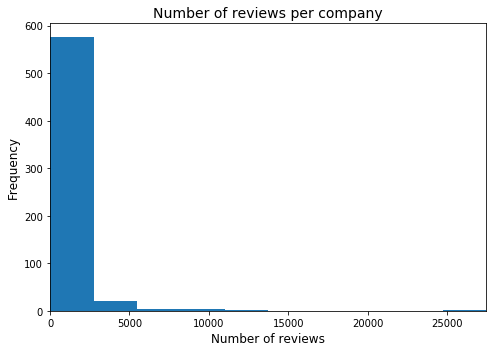

In [26]:
file_path = r'C:\Data\UCL\@MSc Project - Data and sources\Images\histogram01.png'

plt.figure(figsize=(7,5))

ax = (reviews_df
 .groupby('Company')
 .Rating
 .count()
 .plot
 .hist()
)

# set label, title, font size etc.
ax.set_xlabel('Number of reviews', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Number of reviews per company', fontsize=14)
ax.set_xlim((0,companies_filtered_df.TotalReviews.max()))

plt.tight_layout()

plt.savefig(fname=file_path, dpi=300)

**Focused on bottom 90th companies**

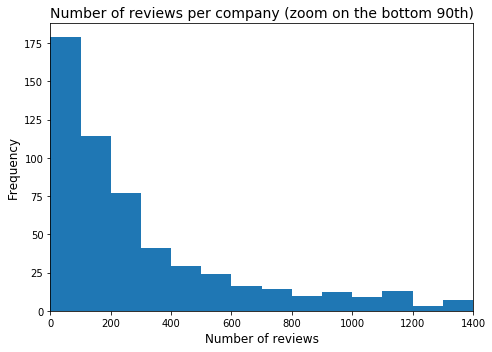

In [27]:
file_path = r'C:\Data\UCL\@MSc Project - Data and sources\Images\histogram01_zoomed.png'

bins = list(range(0, 1500, 100))
bins.append(companies_filtered_df.TotalReviews.max())

plt.figure(figsize=(7,5))

ax = (reviews_df
 .groupby('Company')
 .Rating
 .count()
 .plot
 .hist(bins=bins)
)

# set label, title, font size etc.
ax.set_xlabel('Number of reviews', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Number of reviews per company (zoom on the bottom 90th)', fontsize=14)
ax.set_xlim((0, 1400))

plt.tight_layout()

plt.savefig(fname=file_path, dpi=300)

**Combo**

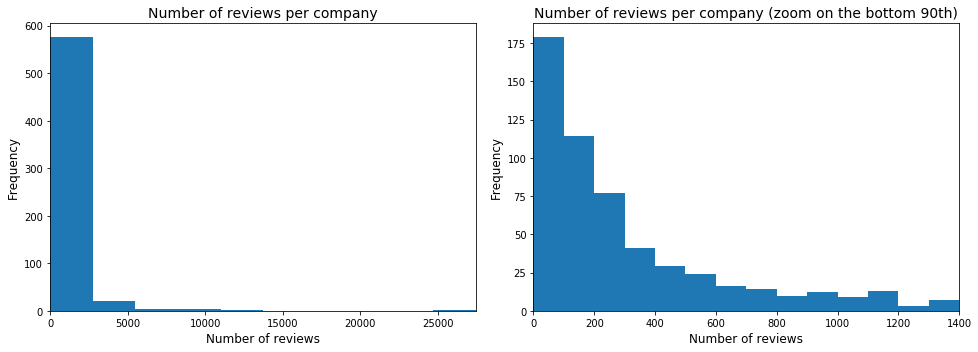

In [28]:
# setup
filepath = r'C:\Data\UCL\@MSc Project - Data and sources\Images\histogram01_combo.png'
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

# global
ax1=(reviews_df
 .groupby('Company')
 .Rating
 .count()
 .hist(ax=ax1, grid=False)
)

ax1.set_xlabel('Number of reviews', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Number of reviews per company', fontsize=14)
ax1.set_xlim((0,companies_filtered_df.TotalReviews.max()))

# zoom
bins = list(range(0, 1500, 100))
bins.append(companies_filtered_df.TotalReviews.max())

ax2=(reviews_df
 .groupby('Company')
 .Rating
 .count()
 .hist(ax=ax2, bins=bins,grid=False)
)

ax2.set_xlabel('Number of reviews', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Number of reviews per company (zoom on the bottom 90th)', fontsize=14)
ax2.set_xlim((0, 1400))

# tight_layout and save
plt.tight_layout()
plt.savefig(fname=filepath, dpi=300)

### 3.3 Mean, meadin, std and quantiles per market and sector

#### 3.3.1 Review length

In [29]:
print(
    companies_filtered_df
    .TotalReviews
    .agg(['mean', 'std', q10, q1, 'median', q3, q90, 'max'])
)   

mean        648.595041
std        1680.993707
q10          39.400000
q1           83.000000
median      214.000000
q3          559.000000
q90        1361.200000
max       27455.000000
Name: TotalReviews, dtype: float64


In [35]:
filepath = r'C:/Data/UCL/@MSc Project - Data and sources/Exploration csv/StockMarket_hist.csv'

(companies_filtered_df
 .groupby('ListedOn')
 .TotalReviews
 .agg(['count', 'mean', 'std', q10, q1, 'median', q3, q90, 'max'])
 .round(2)
).to_csv(filepath)


print(
    companies_filtered_df
    .groupby('ListedOn')
    .TotalReviews
    .agg(['count', 'sum', 'mean', 'std', q10, q1, 'median', q3, q90, 'max'])
    .round(2)
)   

               count     sum    mean      std   q10     q1  median      q3  \
ListedOn                                                                     
EURO STOXX 50     47   21973  467.51   772.73  42.2  69.50   190.0  534.50   
FTSE 100          86   33497  389.50   698.33  27.0  62.25   134.5  322.25   
S&P 500          472  336930  713.83  1859.45  44.1  93.00   222.0  588.00   

                  q90    max  
ListedOn                      
EURO STOXX 50  1043.8   4195  
FTSE 100        968.5   3626  
S&P 500        1443.9  27455  


In [34]:
filepath = r'C:/Data/UCL/@MSc Project - Data and sources/Exploration csv/Sector_hist.csv'

(companies_filtered_df
 .groupby('Sector')
 .TotalReviews
 .agg(['count', 'mean', 'std', q10, q1, 'median', q3, q90, 'max'])
 .round(2)
).to_csv(filepath)


print(
    companies_filtered_df
    .groupby('Sector')
    .TotalReviews
    .agg(['count', 'sum', 'mean', 'std', q10, q1, 'median', q3, q90, 'max'])
    .round(2)
)   

                        count    sum     mean      std   q10      q1  median  \
Sector                                                                         
Basic Materials            31   3798   122.52   173.51  29.0   47.50    62.0   
Communication Services     33  22444   680.12   936.59  41.8   73.00   205.0   
Consumer Cyclical          84  92959  1106.65  3325.23  63.0  111.50   226.5   
Consumer Defensive         52  44658   858.81  1849.34  49.1   92.25   303.0   
Energy                     27   6742   249.70   338.39  32.0   52.00   105.0   
Financial Services         96  59490   619.69   915.15  57.5  113.50   265.0   
Healthcare                 69  31891   462.19   588.24  72.0  127.00   256.0   
Industrials                86  40102   466.30   627.61  44.0   97.25   259.5   
Real Estate                26   3552   136.62   227.54  12.0   18.00    72.5   
Technology                 69  83958  1216.78  2324.17  62.2  127.00   341.0   
Utilities                  32   2806    

In [50]:
filepath = r'C:/Data/UCL/@MSc Project - Data and sources/Exploration csv/Reviews_IndexSector.xlsx'

(companies_filtered_df
 .groupby(['ListedOn', 'Sector'])
 .TotalReviews
 .agg(['mean', 'std', q10, q1, 'median', q3, q90, 'max'])
 .round(2)
).to_excel(filepath)

print(
    companies_filtered_df
    .groupby(['ListedOn', 'Sector'])
    .TotalReviews
    .agg(['sum', 'mean', 'std', q10, q1, 'median', q3, q90, 'max'])
    .round(2)
)   

                                        sum     mean      std    q10       q1  \
ListedOn      Sector                                                            
EURO STOXX 50 Basic Materials           407   101.75    69.11   42.4    55.00   
              Communication Services    734   244.67   234.54   83.8   112.00   
              Consumer Cyclical        1527   254.50   231.45  127.5   147.25   
              Consumer Defensive       2645   529.00   427.76  120.6   237.00   
              Energy                    331   165.50   116.67   99.5   124.25   
              Financial Services       2842   315.78   309.61   53.0    73.00   
              Healthcare               1601   400.25   300.88  104.7   221.25   
              Industrials              4185   597.86   737.02   51.4   123.00   
              Real Estate                66    66.00      NaN   66.0    66.00   
              Technology               7174  2391.33  2115.38  633.6  1489.50   
              Utilities     

In [38]:
(reviews_df
 .groupby('ListedOn')
 .ReviewLength
 .agg(['mean', 'std', q1, 'median', q3])
)

mean         std  q1  median      q3
ListedOn                                                 
EURO STOXX 50  185.329723  240.894163  83     113  188.25
FTSE 100       182.066482  247.465072  80     109  181.00
S&P 500        200.945138  296.729239  81     113  199.00

In [39]:
(reviews_df
 .groupby('Sector')
 .ReviewLength
 .agg(['mean', 'std', q1, 'median', q3])
)

mean         std  q1  median   q3
Sector                                                         
Basic Materials         210.440758  286.775003  85   120.0  219
Communication Services  211.802709  321.028776  82   115.0  207
Consumer Cyclical       192.001581  277.616794  79   110.0  192
Consumer Defensive      184.421335  265.802247  78   108.0  183
Energy                  186.945268  275.337546  83   111.5  182
Financial Services      192.135869  275.714174  81   110.0  189
Healthcare              212.955379  291.809732  84   120.0  218
Industrials             217.018602  324.141355  84   119.0  217
Real Estate             277.623592  369.289958  91   148.0  309
Technology              195.464919  293.258704  81   111.0  191
Utilities               233.952958  342.008030  87   129.0  246

#### 3.3.2 Ratings

In [46]:
filepath = r'C:/Data/UCL/@MSc Project - Data and sources/Exploration csv/Ratings - descriptive stats.csv'

(reviews_df
 .groupby('ListedOn')
 .Rating
 .agg(['mean', 'std', q1, 'median', q3])
 .round(2)
).to_csv(filepath)

print(
    reviews_df
    .groupby('Sector')
    .Rating
    .agg(['mean', 'std', q1, 'median', q3])
    .round(2)
)     

                        mean   std   q1  median   q3
Sector                                              
Basic Materials         3.56  1.23  3.0     4.0  5.0
Communication Services  3.61  1.27  3.0     4.0  5.0
Consumer Cyclical       3.62  1.22  3.0     4.0  5.0
Consumer Defensive      3.40  1.25  3.0     4.0  4.0
Energy                  3.66  1.18  3.0     4.0  5.0
Financial Services      3.59  1.20  3.0     4.0  5.0
Healthcare              3.48  1.29  3.0     4.0  5.0
Industrials             3.59  1.27  3.0     4.0  5.0
Real Estate             3.67  1.36  3.0     4.0  5.0
Technology              3.78  1.15  3.0     4.0  5.0
Utilities               3.54  1.31  3.0     4.0  5.0


In [33]:
print(
    reviews_df
    .groupby('ListedOn')
    .Rating
    .agg(['mean', 'std', q1, 'median', q3])
)     

                   mean       std   q1  median   q3
ListedOn                                           
EURO STOXX 50  3.907796  1.146774  3.0     4.0  5.0
FTSE 100       3.607845  1.202019  3.0     4.0  5.0
S&P 500        3.591372  1.233756  3.0     4.0  5.0


In [52]:
filepath = r'C:/Data/UCL/@MSc Project - Data and sources/Exploration csv/RatingsIndexSector.xlsx'

(reviews_df
 .groupby(['ListedOn', 'Sector'])
 .Rating
 .agg(['mean', 'std', q1, 'median', q3])
 .round(2)
).to_excel(filepath)

print(
    reviews_df
    .groupby(['ListedOn', 'Sector'])
    .Rating
    .agg(['mean', 'std', q1, 'median', q3])
    .round(2)
)     

                                      mean   std   q1  median   q3
ListedOn      Sector                                              
EURO STOXX 50 Basic Materials         3.42  1.34  3.0     4.0  5.0
              Communication Services  3.81  1.06  3.0     4.0  5.0
              Consumer Cyclical       3.80  1.13  3.0     4.0  5.0
              Consumer Defensive      3.71  1.22  3.0     4.0  5.0
              Energy                  3.66  1.21  3.0     4.0  5.0
              Financial Services      3.51  1.20  3.0     4.0  4.0
              Healthcare              3.69  1.16  3.0     4.0  5.0
              Industrials             3.90  1.10  3.0     4.0  5.0
              Real Estate             3.23  1.45  2.0     4.0  4.0
              Technology              4.29  0.98  4.0     5.0  5.0
              Utilities               3.49  1.25  3.0     4.0  4.0
FTSE 100      Basic Materials         3.61  1.22  3.0     4.0  5.0
              Communication Services  3.58  1.21  3.0     4.0 

### 3.4 Monthly mean rating per sector (+ 3M moving average)

In [41]:
reviews_MonthSector = pd.DataFrame(
    reviews_df
    .groupby(['Sector', 'Year-Month'])
    .agg(['count', 'mean'])
)

reviews_MonthSector = pd.DataFrame(
    reviews_MonthSector.to_records()
)[['Sector', 'Year-Month', "('Rating', 'mean')", "('Rating', 'count')"]]

reviews_MonthSector.columns = ['Sector', 'Year-Month', 'Rating', 'Count']

reviews_MonthSector.head()

Sector Year-Month    Rating  Count
0  Basic Materials 2018-07-01  3.507772    193
1  Basic Materials 2018-08-01  3.418079    177
2  Basic Materials 2018-09-01  3.574627    134
3  Basic Materials 2018-10-01  3.450980    153
4  Basic Materials 2018-11-01  3.510949    137

In [42]:
sectors = reviews_MonthSector.Sector.unique()

# add 3-month rating average to the DF
reviews_MonthSector['3M_Average']=0
i=0

for sector in sectors:
    avg = reviews_MonthSector[reviews_MonthSector.Sector==sector].Rating.rolling(window=3).mean()
    
    start = i
    end = i+avg.shape[0]
    reviews_MonthSector.iloc[start:end, -1] = avg
    
    i+=avg.shape[0]

In [ ]:
reviews_MonthSector

### 3.5 Weighted 3M average

In [53]:
s = '1| 3 | 5|7'

[int(x.strip()) for x in s.split('|')]

[1, 3, 5, 7]